In [1]:
from dataclasses import dataclass
from typing import Optional, Tuple

#
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FFMpegWriter, FuncAnimation
from numpy.typing import NDArray
from scipy.signal import fftconvolve
from tqdm import tqdm

from ultrasound_processing import (
    SimParams,
    beamform_das_vectorized,
    make_array_positions,
    make_image_grid,
    simulate_forward_channels_vectorized,
)

# Functional Power Doppler reconstruction

Now that we've demonstrated how to reconstruct structural signals related to the location of scatterers from ultrafast plane-wave ultrasound, let's see how we can detect moving scatterers; these are the source of class 4 contrast in the Greenleaf and Sehgal (1992) classification.

As a reminder, this is the geometry of our transducer and scatterers:

<img src="images/multi_scatterer.png" width="678">

Now let's make those scatterers move!

## Why measure the movement of scatterers?

Red blood cells move through the arteries, arterioles, capillary beds, venules, and ultimately drain into veins. Localized neural activity leads, after a delay of several seconds, to vasodilation, and thus an increase in the speed and number of moving blood cells, a phenomenon known as **neurovascular coupling**. Thus, measuring the speed and density of moving red blood cells allows us to get a proxy of neural activity. This is the same proxy of neural activity used in fMRI, fNIRS, and intrinsic signal imaging. In addition to the intrinsic contrast afforded by red blood cells, it's possible to inject microbubbles in the bloodstream---tiny bubbles of air stabilized by proteins like albumin---to obtain an extrinsic source of contrast, also affected by vasodilation. Thus, to get neural activity, we need measures of scatterer motion.

## How to measure the movement of scatterers

Red blood cells and microbubbles are much smaller than the resolution of ultrasound. Thus, we'll need to look at the statistics of how reconstructed images change rather than attempt to track any particular scatterer. As in the previous tutorial, we start with ultrafast beamformed complex images. By tracking how these images change over time, we can infer how scatterers move in the volume. The critical statistics will be **second-order** statistics: the mean of the images won't tell us about motion, but rather information about scatterer motion will be gleaned from second order statistics, including the variance of images of time, the standard deviation (the square root of the variance), and the field autocorrelation.

Thus, the important structural/function distinction:

* The mean of beamformed images reflect the structure of the volume (structural imaging)
* The second statistics of beamformed images reflect the change in the volume over time, including, in the brain, the hemodynamic response (functional imaging)

## Simulating moving scatterers

We'll simulate a homogeneous field of scatterers. Most of these will be static, but some (between 19 mm and 20 mm depth) will be moving to the right at a speed of 1 mm/s, corresponding to blood flow within parallel arterioles. What happens if we image these scatterers repeatedly? Because we'll be doing a lot of reconstructions, we'll use Numba-optimized versions of the routines we used in the structural reconstruction---cooked up by Claude---, but the logic of the forward and backward simulation is the same.

**Note: Arterioles are <= .1 mm, so think of the region with moving scatterers as 10 arterioles side-to-side. We use a 1 mm region rather than .1 mm for ease of visualization**

In [2]:
P = SimParams()
P.z_span = (0.005, 0.035)  # [m] (5 mm to 35 mm)
P.n_bg = 8000

With these parameters, it will take ~400 us to take one image with a penetration up to 3.5cm, accumulating over the different angles.

In [3]:
time_per_frame = len(P.angles_deg) * (2 * P.z_span[1]) / P.c
time_per_frame

0.0004090909090909092

Because each frame is so fast, scatterers will move by a very small amount at every frame. For the movement to be visible, we will need to look at how the signal evolves over very many frames, which would require lots of simulations. Instead, we'll take a snapshot of the field every 10 ms, skipping ahead by 25 frames x 400 us = 10 ms. In real world, we would instead average several fast B frames to beat sensor noise.

In [4]:
fps = 100

## Setup: Create phantom

Scatterers inside arterioles: 303 / 8000


(np.float64(-9.897955761511518),
 np.float64(9.899841684910765),
 np.float64(36.74584974374656),
 np.float64(-1.7498023687498365))

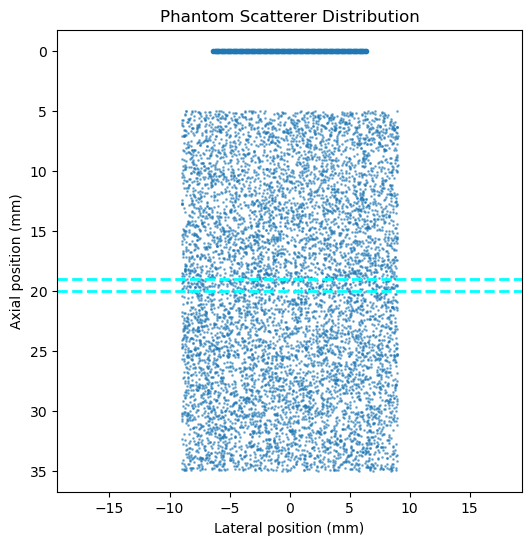

In [5]:
def sample_scatterers(
    P: SimParams, rng=np.random.default_rng(0)
) -> Tuple[NDArray, NDArray]:
    """Sample background scatterers and assign reflectivity"""
    x0, x1 = P.x_span
    z0, z1 = P.z_span
    # Background random positions
    xs = rng.uniform(x0, x1, P.n_bg)
    zs = rng.uniform(z0, z1, P.n_bg)
    scat = np.column_stack([xs, zs]).astype(np.float64)  # (S, 2)
    amp = np.full(P.n_bg, 1.0, dtype=np.float64)
    return scat, amp


vessel_z_min = 19e-3
vessel_z_max = 20e-3

elem_pos = make_array_positions(P.Ne, P.pitch, P.center_x)
scat_pos, scat_amp = sample_scatterers(P)

# Plot the phantom
plt.figure(figsize=(6, 6))
plt.scatter(scat_pos[:, 0] * 1e3, scat_pos[:, 1] * 1e3, s=1, alpha=0.5)
plt.plot(elem_pos * 1e3, np.zeros_like(elem_pos) * 1e3, "o", markersize=3)

plt.axhline(
    y=vessel_z_min * 1e3,
    color="cyan",
    linestyle="--",
    linewidth=2,
    label="Vessel region",
)
plt.axhline(y=vessel_z_max * 1e3, color="cyan", linestyle="--", linewidth=2)

# Show how many scatterers are inside the inclusion
inside_mask = (scat_pos[:, 1] >= vessel_z_min) & (scat_pos[:, 1] <= vessel_z_max)
print(f"Scatterers inside arterioles: {inside_mask.sum()} / {len(scat_amp)}")
plt.xlabel("Lateral position (mm)")
plt.ylabel("Axial position (mm)")
plt.title("Phantom Scatterer Distribution")
plt.ylim(40, -5)
plt.axis("equal")

## Simulating reconstruction over time

Do the forward simulation. Note that the scatterers within the vessel get a constant drift to the right plus a little bit of a jitter.

In [6]:
# Reset scatterers to initial positions
scat_pos, scat_amp = sample_scatterers(P)

# Run 50 simulations
n_frames = 50
Ys = []

vessel_mask = (scat_pos[:, 1] >= vessel_z_min) & (scat_pos[:, 1] <= vessel_z_max)
flow_speed = 0.001

print(f"Running {n_frames} forward simulations...")
for i in tqdm(range(n_frames)):
    # Simulate current frame
    Y, times, elem_pos, _, _, _ = simulate_forward_channels_vectorized(
        P, scat_pos, scat_amp
    )
    Ys.append(Y)

    # Coherent rightward motion for scatterers in vessel
    displacement = np.zeros_like(scat_pos)
    displacement[vessel_mask, 0] = flow_speed / fps  # Move right (+x)

    # Optional: add small random perturbation for realism
    displacement[vessel_mask, 0] += np.random.normal(
        scale=flow_speed * 0.1 / fps, size=(vessel_mask.sum(),)
    )

    scat_pos += displacement
    # Wrap around scatterers that move beyond x_span
    scat_pos[:, 0] = (scat_pos[:, 0] - P.x_span[0]) % (
        P.x_span[1] - P.x_span[0]
    ) + P.x_span[0]

Running 50 forward simulations...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


And reconstruct the images.

In [7]:
# Beamform all frames
print(f"Reconstructing {len(Ys)} frames...")
alpha = P.f_carrier / 1e6 / 8.686 * P.alpha_db_cm_mhz * 100
betas = np.deg2rad(P.angles_deg)
x, z, X, Z = make_image_grid(P.x_span, P.z_span, 0.1e-3, 0.1e-3)
imgs_complex = []
for Y in tqdm(Ys):
    img_complex = beamform_das_vectorized(
        Y, times, elem_pos, x, z, P.c, betas, 2 * np.pi * P.f_carrier, alpha
    )
    imgs_complex.append(img_complex)

print(f"✓ Collected {len(Ys)} frames")
print(f"  Each frame shape: {Ys[0].shape}")

Reconstructing 50 frames...


✓ Collected 50 frames
  Each frame shape: (9, 128, 1920)


In [8]:
# Create animation of the ultrasound images through time
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# Find global min/max for consistent color scaling
all_real = np.array([img.real for img in imgs_complex])
all_abs = np.array([np.abs(img) for img in imgs_complex])
vmin_abs, vmax_abs = np.percentile(all_abs, [1, 99])

# Initialize plots
ax1 = axes
im1 = ax1.imshow(
    all_abs[0],
    extent=[x[0] * 1e3, x[-1] * 1e3, z[-1] * 1e3, z[0] * 1e3],
    aspect="equal",
    cmap="gray",
    vmin=vmin_abs,
    vmax=vmax_abs,
)
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("z (mm)")
ax1.set_title("B-mode")
plt.colorbar(im1, ax=ax1)

# Add vessel region markers
ax1.axhline(y=vessel_z_min * 1e3, color="cyan", linestyle="--", linewidth=1, alpha=0.5)
ax1.axhline(y=vessel_z_max * 1e3, color="cyan", linestyle="--", linewidth=1, alpha=0.5)

# Add time text
time_text = fig.text(
    0.5,
    0.95,
    "",
    ha="center",
    fontsize=14,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
)


def init():
    im1.set_array(all_abs[0])
    time_text.set_text("")
    return im1, time_text


def animate(frame):
    # Update images
    im1.set_array(all_abs[frame])

    # Update time text
    time_ms = frame / fps * 1000  # Convert to milliseconds
    time_text.set_text(f"Frame {frame+1}/{len(imgs_complex)} | Time: {time_ms:.2f} ms")

    return im1, time_text


# Create animation
anim = FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(imgs_complex),
    interval=50,
    blit=True,
    repeat=True,
)

# Option 1: Display in notebook (HTML5 video)
plt.close()
HTML(anim.to_jshtml())

Animation removed for publishing.

We can clearly see the movement in the vessel, with the pattern of speckle moving to the right. Let's do some basic signal processing to highlight the movement.

## First-order reconstruction

If we simply average the frames, we can guess at the presence of the artery by the fact that the speckle pattern is less visible there, because it averages over several cycles.

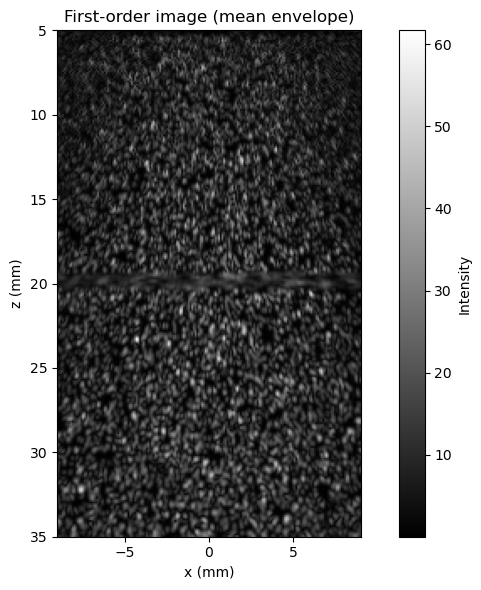

In [9]:
# Compute envelope (magnitude) for each frame
imgs_env = np.array([np.abs(img) for img in imgs_complex])

# First-order: mean
img_mean = imgs_env.mean(axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(
    img_mean,
    extent=[x[0] * 1e3, x[-1] * 1e3, z[-1] * 1e3, z[0] * 1e3],
    aspect="equal",
    cmap="gray",
)
plt.xlabel("x (mm)")
plt.ylabel("z (mm)")
plt.title("First-order image (mean envelope)")
plt.colorbar(label="Intensity")
plt.tight_layout()
plt.show()

The inclusion is barely visible as a change in texture, because moving scatterers average out the speckle pattern over time.

## Second-order reconstruction (Power Doppler)

However, the movement of the scatterers distorts the second order statistics of the signal. The movement of scatterers can be read out by calculating the standard deviation of the stack of images over time:

$$\text{PD} = \sqrt{\frac{1}{N} \sum_i |\tilde s(i)|^2}$$

PD = Power Doppler. Here $\tilde s(i)$ is the *i*'th complex beamformed image with the temporal mean removed.

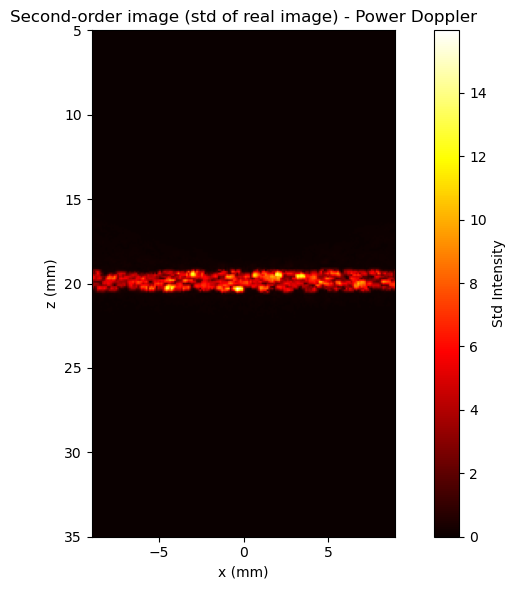

In [10]:
# Second-order: standard deviation
img_std = imgs_env.std(axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(
    img_std,
    extent=[x[0] * 1e3, x[-1] * 1e3, z[-1] * 1e3, z[0] * 1e3],
    aspect="equal",
    cmap="hot",
)
plt.xlabel("x (mm)")
plt.ylabel("z (mm)")
plt.title("Second-order image (std of real image) - Power Doppler")
plt.colorbar(label="Std Intensity")

plt.tight_layout()
plt.show()

The inclusion is clearly visible in the second-order statistics! The standard deviation of rapidly acquired images is known as the **Power Doppler image**.

Now, let's dig in more into the Power Doppler signal and ask what it reflects: how sensitive is it to the geometry of the flow? Does it depend on the speed of the moving scatterers, or their total number? When we measure the Power Doppler signal in brains, is it proportional to cerebral blood *flow* or cerebral blood *volume*, or something else?

# Out-of-plane motion

We see that we can measure coherent scatterer movement in the x direction; we could repeat the same for movement in the z direction; but what if the scatterers are moving out-of-plane, in the y direction? Let's simulate and see what happens.

Assuming the scatterers are red blood cells, their largest dimension is ~8 micrometers. If blood flow is at 1 mm/s, and we image at 100 Hz, that means red blood cells will move 10 um per frame, so they'll only stay in place for ~1 frame; we'll simulate this by assuming we get a brand new spatial configuration of of scatterers within a 1 mm radius at the center of the imaging volume.

In [11]:
def generate_random_points_in_circle(
    radius, n_points, center_x=0, center_y=0, rng=None
):
    """
    Generates random points uniformly distributed within a circle.

    Args:
        radius (float): The radius of the circle.
        n_points (int): Number of points to generate.
        center_x (float): The x-coordinate of the circle's center. Default is 0.
        center_y (float): The y-coordinate of the circle's center. Default is 0.
        rng (np.random.Generator): Optional random number generator. If None, uses default.

    Returns:
        tuple: A tuple (x, y) where x and y are arrays of shape (n_points,)
               representing the coordinates of the random points.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Generate random angles
    theta = rng.uniform(0, 2 * np.pi, size=n_points)

    # Generate random radii (using square root for uniform distribution)
    r = radius * np.sqrt(rng.uniform(0, 1, size=n_points))

    # Calculate Cartesian coordinates
    x = center_x + r * np.cos(theta)
    y = center_y + r * np.sin(theta)

    return x, y

In [12]:
# Reset scatterers to initial positions
scat_pos, scat_amp = sample_scatterers(P)

x_center = 0
z_center = 20e-3
mask = (scat_pos[:, 0] - x_center) ** 2 + (scat_pos[:, 1] - z_center) ** 2 <= (
    0.5e-3
) ** 2

# Run 50 simulations
n_frames = 50
Ys = []

vessel_mask = (scat_pos[:, 1] >= vessel_z_min) & (scat_pos[:, 1] <= vessel_z_max)
flow_speed = 0.001

print(f"Running {n_frames} forward simulations...")
for i in tqdm(range(n_frames)):
    # Simulate current frame
    Y, times, elem_pos, _, _, _ = simulate_forward_channels_vectorized(
        P, scat_pos, scat_amp
    )
    Ys.append(Y)

    # Wrap around scatterers that move beyond x_span
    xp, zp = generate_random_points_in_circle(
        0.5e-3, mask.sum(), center_x=0, center_y=z_center
    )
    scat_pos[mask, 0] = xp
    scat_pos[mask, 1] = zp

Running 50 forward simulations...


In [13]:
# Beamform all frames
print(f"Reconstructing {len(Ys)} frames...")
imgs_complex = []
for Y in tqdm(Ys):
    img_complex = beamform_das_vectorized(
        Y, times, elem_pos, x, z, P.c, betas, 2 * np.pi * P.f_carrier, alpha
    )
    imgs_complex.append(img_complex)

print(f"✓ Collected {len(Ys)} frames")
print(f"  Each frame shape: {Ys[0].shape}")

Reconstructing 50 frames...


✓ Collected 50 frames
  Each frame shape: (9, 128, 1920)


In [14]:
# Create animation of the ultrasound images through time
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# Find global min/max for consistent color scaling
all_real = np.array([img.real for img in imgs_complex])
all_abs = np.array([np.abs(img) for img in imgs_complex])
vmin_real, vmax_real = np.percentile(all_real, [1, 99])
vmin_abs, vmax_abs = 0, np.percentile(all_abs, 99)

# Initialize plots
ax1 = axes
im1 = ax1.imshow(
    np.abs(imgs_complex[0]),
    extent=[x[0] * 1e3, x[-1] * 1e3, z[-1] * 1e3, z[0] * 1e3],
    aspect="equal",
    cmap="gray",
    vmin=vmin_abs,
    vmax=vmax_abs,
)
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("z (mm)")
ax1.set_title("B-mode")
plt.colorbar(im1, ax=ax1)

# Add time text
time_text = fig.text(
    0.5,
    0.95,
    "",
    ha="center",
    fontsize=14,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
)


def init():
    im1.set_array(np.abs(imgs_complex[0]))
    time_text.set_text("")
    return im1, time_text


def animate(frame):
    # Update images
    im1.set_array(np.abs(imgs_complex[frame]))

    # Update time text
    time_ms = frame / fps * 1000  # Convert to milliseconds
    time_text.set_text(f"Frame {frame+1}/{len(imgs_complex)} | Time: {time_ms:.2f} ms")

    return im1, time_text


# Create animation
anim = FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(imgs_complex),
    interval=50,
    blit=True,
    repeat=True,
)

# Option 1: Display in notebook (HTML5 video)
plt.close()
HTML(anim.to_jshtml())

Animation removed for publishing.

Notice the changing speckle pattern in the center of volume. We can detect it using second order statistics as before:

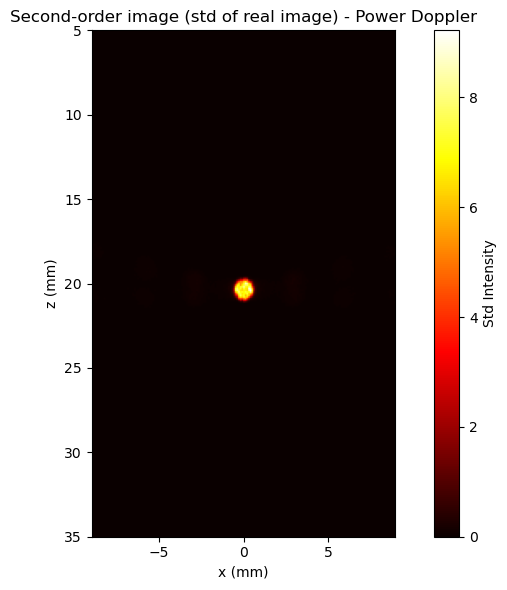


✓ The inclusion is clearly visible in the second-order reconstruction!
  This demonstrates functional ultrasound (Power Doppler) imaging.


In [15]:
# Second-order: standard deviation
imgs_env = np.array([np.abs(img) for img in imgs_complex])
img_std = imgs_env.std(axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(
    img_std,
    extent=[x[0] * 1e3, x[-1] * 1e3, z[-1] * 1e3, z[0] * 1e3],
    aspect="equal",
    cmap="hot",
)
plt.xlabel("x (mm)")
plt.ylabel("z (mm)")
plt.title("Second-order image (std of real image) - Power Doppler")
plt.colorbar(label="Std Intensity")

plt.tight_layout()
plt.show()

print("\n✓ The inclusion is clearly visible in the second-order reconstruction!")
print("  This demonstrates functional ultrasound (Power Doppler) imaging.")

Notice the clearly visible motion.

# Sensitivity to speed

What happens as the speed of the diffusers change over time?

Testing 8 different flow speeds:
  Speed 1: 0.0 mm/s
  Speed 2: 0.2 mm/s
  Speed 3: 0.5 mm/s
  Speed 4: 1.0 mm/s
  Speed 5: 2.0 mm/s
  Speed 6: 4.0 mm/s
  Speed 7: 8.0 mm/s
  Speed 8: 16.0 mm/s

Blood vessel region: z = 19.0 to 20.0 mm
Flow direction: rightward (+x)
Scatterers in vessel: 299 / 8000


Scatterers in vessel: 289 / 8000


Scatterers in vessel: 271 / 8000


Scatterers in vessel: 273 / 8000


Scatterers in vessel: 270 / 8000


Scatterers in vessel: 237 / 8000


Scatterers in vessel: 254 / 8000


Scatterers in vessel: 282 / 8000


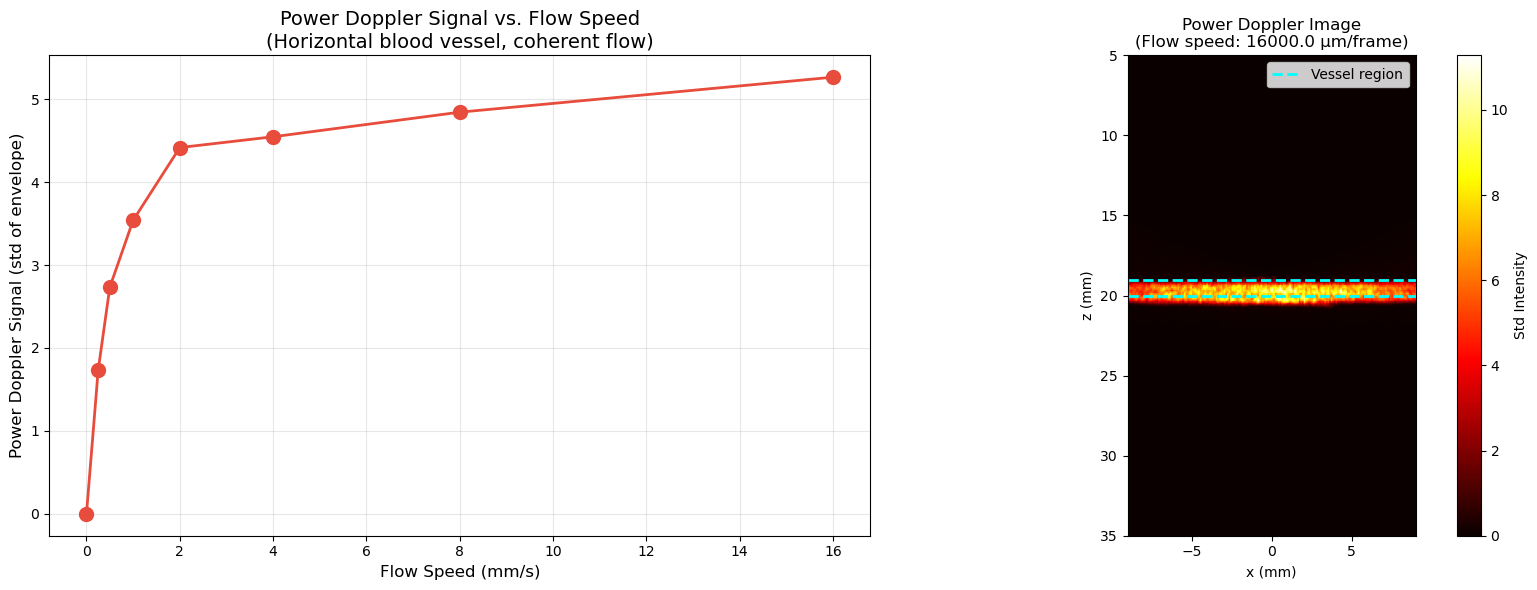

In [16]:
# Test different flow speeds (coherent rightward motion)
fps = 100  # frames per second
flow_speeds = np.array(
    [0, 0.00025, 0.0005, 0.001, 0.002, 0.004, 0.008, 0.016]
)  # Range from very slow to fast flow [m]

print(f"Testing {len(flow_speeds)} different flow speeds:")
for i, speed in enumerate(flow_speeds):
    print(f"  Speed {i+1}: {speed*1e3:.1f} mm/s")

# Define blood vessel region (horizontal stripe)
vessel_z_min = 0.019  # 19 mm
vessel_z_max = 0.020  # 20 mm

print(f"\nBlood vessel region: z = {vessel_z_min*1e3:.1f} to {vessel_z_max*1e3:.1f} mm")
print("Flow direction: rightward (+x)")

# Storage for results
power_doppler_signals = []

for speed_idx, flow_speed in enumerate(flow_speeds):

    # Reset scatterers to initial positions
    scat_pos_test, scat_amP = sample_scatterers(P)

    # Identify scatterers in the vessel region
    z_coords = scat_pos_test[:, 1]
    vessel_mask = (z_coords >= vessel_z_min) & (z_coords <= vessel_z_max)

    print(f"Scatterers in vessel: {vessel_mask.sum()} / {len(scat_amP)}")

    # Run simulations
    n_frames_test = 50
    Ys_test = []

    for i in tqdm(range(n_frames_test), desc=f"Flow {flow_speed*1000:.1f}mm/s"):
        # Simulate current frame
        Y_test, t_test, elem_pos_test, _, _, _ = simulate_forward_channels_vectorized(
            P, scat_pos_test, scat_amP
        )
        Ys_test.append(Y_test)

        # Move scatterers in vessel region coherently to the right
        if i < n_frames_test - 1:
            # Coherent rightward motion for scatterers in vessel
            displacement = np.zeros_like(scat_pos_test)
            displacement[vessel_mask, 0] = flow_speed / fps  # Move right (+x)

            # Optional: add small random perturbation for realism
            displacement[vessel_mask] += np.random.normal(
                scale=flow_speed * 0.1 / fps, size=(vessel_mask.sum(), 2)
            )

            scat_pos_test += displacement
            # Wrap around scatterers that move beyond x_span
            scat_pos_test[:, 0] = (scat_pos_test[:, 0] - P.x_span[0]) % (
                P.x_span[1] - P.x_span[0]
            ) + P.x_span[0]

    # Beamform all frames
    imgs_complex_test = []
    for Y_test in tqdm(Ys_test, desc="Beamforming"):
        img_complex_test = img_complex = beamform_das_vectorized(
            Y_test,
            times,
            elem_pos_test,
            x,
            z,
            P.c,
            betas,
            2 * np.pi * P.f_carrier,
            alpha,
        )
        imgs_complex_test.append(img_complex_test)

    # Compute envelope and variance
    imgs_env_test = np.array([np.abs(img) for img in imgs_complex_test])
    img_std_test = imgs_env_test.std(axis=0)

    # Create mask for pixels in the vessel region
    X_grid, Z_grid = np.meshgrid(x, z)
    vessel_pixel_mask = (Z_grid >= vessel_z_min) & (Z_grid <= vessel_z_max)

    # Average the Power Doppler signal over the vessel region
    center_signal = img_std_test[vessel_pixel_mask].mean()
    power_doppler_signals.append(center_signal)

power_doppler_signals = np.array(power_doppler_signals)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Power Doppler signal vs speed
ax1.plot(
    flow_speeds * 1e3,
    power_doppler_signals,
    "o-",
    linewidth=2,
    markersize=10,
    color="#e74c3c",
)
ax1.set_xlabel("Flow Speed (mm/s)", fontsize=12)
ax1.set_ylabel("Power Doppler Signal (std of envelope)", fontsize=12)
ax1.set_title(
    "Power Doppler Signal vs. Flow Speed\n(Horizontal blood vessel, coherent flow)",
    fontsize=14,
)
ax1.grid(True, alpha=0.3)

# Right: Show the vessel region on the Power Doppler image (last speed)
im = ax2.imshow(
    img_std_test,
    extent=[x[0] * 1e3, x[-1] * 1e3, z[-1] * 1e3, z[0] * 1e3],
    aspect="equal",
    cmap="hot",
)
ax2.axhline(
    y=vessel_z_min * 1e3,
    color="cyan",
    linestyle="--",
    linewidth=2,
    label="Vessel region",
)
ax2.axhline(y=vessel_z_max * 1e3, color="cyan", linestyle="--", linewidth=2)
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_title(f"Power Doppler Image\n(Flow speed: {flow_speeds[-1]*1e6:.1f} µm/frame)")
ax2.legend(loc="upper right")
plt.colorbar(im, ax=ax2, label="Std Intensity")

plt.tight_layout()
plt.show()

Although the PD signal saturates with flow speed, it is ~linear in the physiological range for veinules and arterioles (mm/s). However, Demené et al. (2014) state that:

> It is important to underline that the Power Doppler signal, proportional to the blood volume in the pixel, does not increase in theory with the blood flow speed, but only with the number of red blood cells in the pixel

Why the discrepancy at low speeds?

It all depends on the window over which we average the signal. Let's look at what happens to reconstructed images when blood flows at 2 mm/s over many frames. We'll take a horizontal slice of the 2d images through the artery so we can easily examine the reconstruction through time.

In [17]:
# Test different flow speeds (coherent rightward motion)
fps = 100  # frames per second
flow_speed = 0.002

# Define blood vessel region (horizontal stripe)
vessel_z_min = 0.019  # 19 mm
vessel_z_max = 0.020  # 20 mm

print(f"\nBlood vessel region: z = {vessel_z_min*1e3:.1f} to {vessel_z_max*1e3:.1f} mm")
print("Flow direction: rightward (+x)")

# Storage for results
power_doppler_signals = []

# Reset scatterers to initial positions
scat_pos_test, scat_amP = sample_scatterers(P)

# Identify scatterers in the vessel region
z_coords = scat_pos_test[:, 1]
vessel_mask = (z_coords >= vessel_z_min) & (z_coords <= vessel_z_max)

print(f"Scatterers in vessel: {vessel_mask.sum()} / {len(scat_amP)}")

# Run simulations
n_frames_test = 200
Ys_test = []

for i in tqdm(range(n_frames_test)):
    # Simulate current frame
    Y_test, times, elem_pos_test, _, _, _ = simulate_forward_channels_vectorized(
        P, scat_pos_test, scat_amP
    )
    Ys_test.append(Y_test)

    # Move scatterers in vessel region coherently to the right
    if i < n_frames_test - 1:
        # Coherent rightward motion for scatterers in vessel
        displacement = np.zeros_like(scat_pos_test)
        displacement[vessel_mask, 0] = flow_speed / fps  # Move right (+x)

        # Optional: add small random perturbation for realism
        displacement[vessel_mask] += np.random.normal(
            scale=flow_speed * 0.1 / fps, size=(vessel_mask.sum(), 2)
        )

        scat_pos_test += displacement
        # Wrap around scatterers that move beyond x_span
        scat_pos_test[:, 0] = (scat_pos_test[:, 0] - P.x_span[0]) % (
            P.x_span[1] - P.x_span[0]
        ) + P.x_span[0]

# Beamform all frames
imgs_complex_test = []
for Y_test in tqdm(Ys_test, desc="Beamforming"):
    img_complex_test = img_complex = beamform_das_vectorized(
        Y_test, t_test, elem_pos_test, x, z, P.c, betas, 2 * np.pi * P.f_carrier, alpha
    )
    imgs_complex_test.append(img_complex_test)

# Compute envelope and variance
imgs_env_test = np.array([np.abs(img) for img in imgs_complex_test])
img_std_test = imgs_env_test.std(axis=0)

# Create mask for pixels in the vessel region
X_grid, Z_grid = np.meshgrid(x, z)
middle_line = int(np.where((z >= vessel_z_min) & (z <= vessel_z_max))[0].mean())

# Pick the middle line in the vessel region
center_pos = imgs_env_test[:, middle_line, :]


Blood vessel region: z = 19.0 to 20.0 mm
Flow direction: rightward (+x)
Scatterers in vessel: 266 / 8000


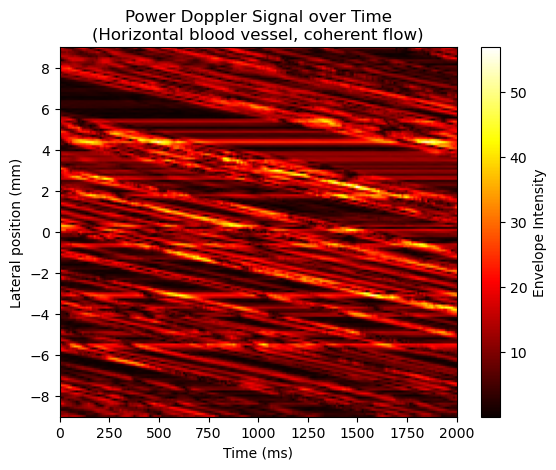

In [18]:
plt.imshow(
    center_pos.T,
    aspect="auto",
    cmap="hot",
    extent=[0, n_frames_test / fps * 1000, x[0] * 1e3, x[-1] * 1e3],
)
plt.xlabel("Time (ms)")
plt.ylabel("Lateral position (mm)")
plt.title("Power Doppler Signal over Time\n(Horizontal blood vessel, coherent flow)")
plt.colorbar(label="Envelope Intensity")

The signal drifts very slowly over time (at the speed of blood flow, 2 mm /s). Hence, the standard deviation looks smaller if taken over a small window of time.

Text(0.5, 1.0, 'Power Doppler Signal vs. Averaging Time')

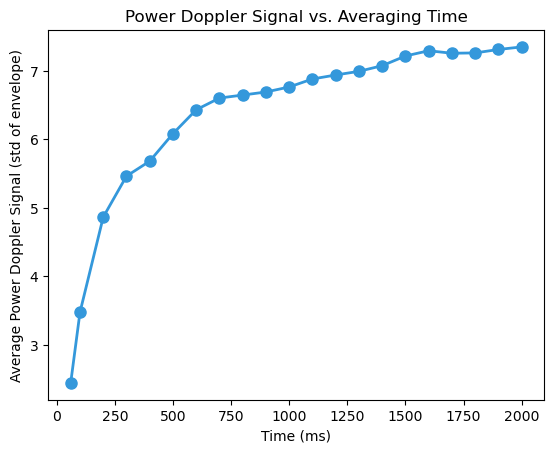

In [19]:
pd_signals = []
num_frames = np.array(
    [
        6,
        10,
        20,
        30,
        40,
        50,
        60,
        70,
        80,
        90,
        100,
        110,
        120,
        130,
        140,
        150,
        160,
        170,
        180,
        190,
        200,
    ]
)
for nf in num_frames:
    avg_signal = center_pos[:nf, :].std(axis=0)
    pd_signals.append(avg_signal[(x >= -5e-3) & (x <= 5e-3)].mean())

plt.plot(
    num_frames / fps * 1000,
    pd_signals,
    "o-",
    linewidth=2,
    markersize=8,
    color="#3498db",
)
plt.xlabel("Time (ms)")
plt.ylabel("Average Power Doppler Signal (std of envelope)")
plt.title("Power Doppler Signal vs. Averaging Time")

We only reach the peak signal once speckle has had time to roll over. So the statement that "the PD signal is not sensitive to flow" is only true in the limit of long averaging windows and high speeds.

# Density of scatterers

Let's double-check that PD is sensitive to the density of scatterers. The variance of the images should grow in proportion to the number of scatterers, which means that the PD signal should grow as the *square root* of the number of scatterers.

Scatterers in vessel: 270 / 8000


Scatterers in vessel: 414 / 8138


Scatterers in vessel: 540 / 8270


Scatterers in vessel: 1036 / 8777


Scatterers in vessel: 2272 / 9988


Scatterers in vessel: 4496 / 12215


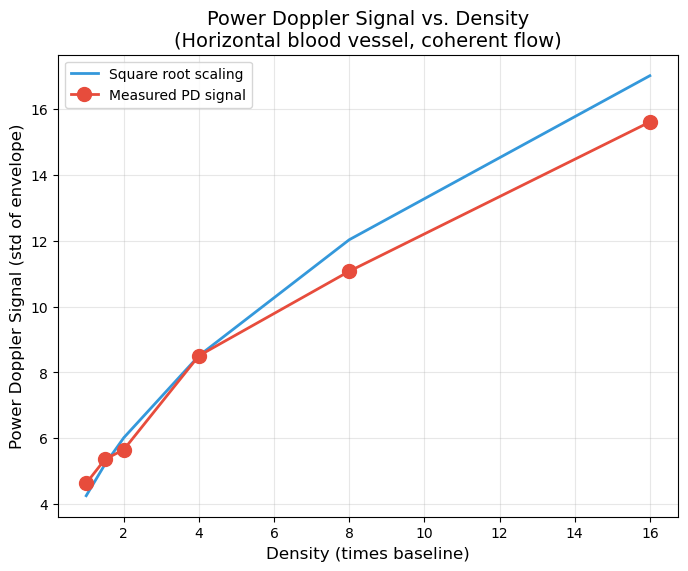

In [20]:
# Test different flow speeds (coherent rightward motion)
fps = 100  # frames per second
flow_speed = 0.002

# Define blood vessel region (horizontal stripe)
vessel_z_min = 0.019  # 19 mm
vessel_z_max = 0.020  # 20 mm

# Storage for results
power_doppler_signals = []

densities = np.array([1, 1.5, 2, 4, 8, 16])

for density in densities:

    # Reset scatterers to initial positions
    scat_pos_test, scat_amP = sample_scatterers(P)

    # Identify scatterers in the vessel region
    z_coords = scat_pos_test[:, 1]
    vessel_mask = (z_coords >= vessel_z_min) & (z_coords <= vessel_z_max)

    # Add more scatterers in the vessel region to see how it affects the PD signal
    if density > 1:
        # Sample additional scatterers in the vessel region
        n_additional_scat = int(vessel_mask.sum() * (density - 1))
        x_add, z_add = np.random.uniform(
            low=[P.x_span[0], vessel_z_min],
            high=[P.x_span[1], vessel_z_max],
            size=(n_additional_scat, 2),
        ).T
        scat_pos_test = np.vstack([scat_pos_test, np.column_stack([x_add, z_add])])
        scat_amP = np.hstack(
            [scat_amP, np.random.normal(loc=0, scale=1, size=n_additional_scat)]
        )

        vessel_mask = (scat_pos_test[:, 1] >= vessel_z_min) & (
            scat_pos_test[:, 1] <= vessel_z_max
        )

    print(f"Scatterers in vessel: {vessel_mask.sum()} / {len(scat_amP)}")

    # Run simulations
    n_frames_test = 50
    Ys_test = []

    for i in tqdm(range(n_frames_test), desc=f"Density {density}X"):
        # Simulate current frame
        Y_test, t_test, elem_pos_test, _, _, _ = simulate_forward_channels_vectorized(
            P, scat_pos_test, scat_amP
        )
        Ys_test.append(Y_test)

        # Move scatterers in vessel region coherently to the right
        if i < n_frames_test - 1:
            # Coherent rightward motion for scatterers in vessel
            displacement = np.zeros_like(scat_pos_test)
            displacement[vessel_mask, 0] = flow_speed / fps  # Move right (+x)

            # Optional: add small random perturbation for realism
            displacement[vessel_mask] += np.random.normal(
                scale=flow_speed * 0.1 / fps, size=(vessel_mask.sum(), 2)
            )

            scat_pos_test += displacement
            # Wrap around scatterers that move beyond x_span
            scat_pos_test[:, 0] = (scat_pos_test[:, 0] - P.x_span[0]) % (
                P.x_span[1] - P.x_span[0]
            ) + P.x_span[0]

    # Beamform all frames
    imgs_complex_test = []
    for Y_test in tqdm(Ys_test, desc="Beamforming"):
        img_complex_test = beamform_das_vectorized(
            Y_test,
            t_test,
            elem_pos_test,
            x,
            z,
            P.c,
            betas,
            2 * np.pi * P.f_carrier,
            alpha,
        )
        imgs_complex_test.append(img_complex_test)

    # Compute envelope and variance
    imgs_env_test = np.array([np.abs(img) for img in imgs_complex_test])
    img_std_test = imgs_env_test.std(axis=0)

    # Create mask for pixels in the vessel region
    X_grid, Z_grid = np.meshgrid(x, z)
    vessel_pixel_mask = (Z_grid >= vessel_z_min) & (Z_grid <= vessel_z_max)

    # Average the Power Doppler signal over the vessel region
    center_signal = img_std_test[vessel_pixel_mask].mean()
    power_doppler_signals.append(center_signal)

power_doppler_signals = np.array(power_doppler_signals)

# Plot results
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

# Left: Power Doppler signal vs speed
ax1.plot(
    densities,
    np.sqrt(densities) * power_doppler_signals[densities == 4] / 2,
    "-",
    linewidth=2,
    markersize=10,
    color="#3498db",
    label="Square root scaling",
)
ax1.plot(
    densities,
    power_doppler_signals,
    "o-",
    linewidth=2,
    markersize=10,
    color="#e74c3c",
    label="Measured PD signal",
)
ax1.set_xlabel("Density (times baseline)", fontsize=12)
ax1.set_ylabel("Power Doppler Signal (std of envelope)", fontsize=12)
ax1.set_title(
    "Power Doppler Signal vs. Density\n(Horizontal blood vessel, coherent flow)",
    fontsize=14,
)
ax1.grid(True, alpha=0.3)
ax1.legend()

Indeed, the PD signal grows as the square root of the number of scatterers. This confirms that Power Doppler is sensitive to blood *volume* (number of red blood cells or microbubbles) rather than flow speed.

# Sensitivity to flow angle

Is the PD signal sensitive to the angle of the movement?

What happens as the angle of the flow changes? We'll test angles from 0° to 45° in 5° increments, measuring the Power Doppler signal within a rotated rectangular region (10 mm wide × 1 mm high) that aligns with the flow direction.

Testing 10 different flow angles at fixed speed 1.0 mm/s:
  Angle 1: 0°
  Angle 2: 5°
  Angle 3: 10°
  Angle 4: 15°
  Angle 5: 20°
  Angle 6: 25°
  Angle 7: 30°
  Angle 8: 35°
  Angle 9: 40°
  Angle 10: 45°

Measurement region: 10.0 mm wide × 1.0 mm high
Centered at: x=0.0 mm, z=20.0 mm

Angle 0°: Scatterers in region: 142 / 8000


Pixels in measurement region: 1000

Angle 5°: Scatterers in region: 165 / 8000


Pixels in measurement region: 999

Angle 10°: Scatterers in region: 143 / 8000


Pixels in measurement region: 1003

Angle 15°: Scatterers in region: 136 / 8000


Pixels in measurement region: 1001

Angle 20°: Scatterers in region: 146 / 8000


Pixels in measurement region: 999

Angle 25°: Scatterers in region: 143 / 8000


Pixels in measurement region: 995

Angle 30°: Scatterers in region: 137 / 8000


Pixels in measurement region: 998

Angle 35°: Scatterers in region: 157 / 8000


Pixels in measurement region: 1003

Angle 40°: Scatterers in region: 151 / 8000


Pixels in measurement region: 999

Angle 45°: Scatterers in region: 137 / 8000


Pixels in measurement region: 1057


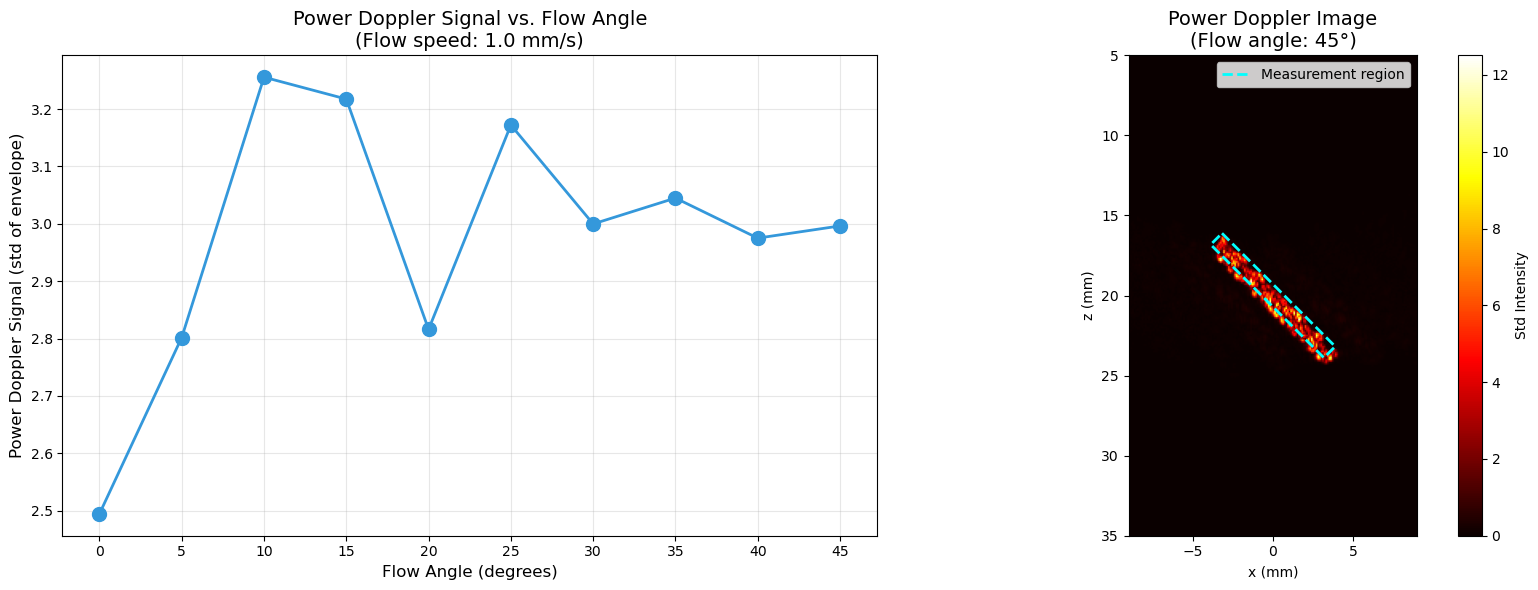


✓ Completed angle sensitivity analysis
  PD signal variation: 2.4943 to 3.2555


In [21]:
# Test different flow angles
fps = 100  # frames per second
flow_speed = 0.001  # Fixed flow speed: 1 mm/s
flow_angles_deg = np.arange(0, 50, 5)  # 0° to 45° in 5° increments

print(
    f"Testing {len(flow_angles_deg)} different flow angles at fixed speed {flow_speed*1e3:.1f} mm/s:"
)
for i, angle in enumerate(flow_angles_deg):
    print(f"  Angle {i+1}: {angle}°")

# Define rectangular measurement region (centered at x=0, z=20mm)
# 10 mm wide (x) × 1 mm high (z)
rect_center_x = 0.0
rect_center_z = 0.020  # 20 mm
rect_width = 0.010  # 10 mm (lateral)
rect_height = 0.001  # 1 mm (axial)

print(
    f"\nMeasurement region: {rect_width*1e3:.1f} mm wide × {rect_height*1e3:.1f} mm high"
)
print(f"Centered at: x={rect_center_x*1e3:.1f} mm, z={rect_center_z*1e3:.1f} mm")

# Storage for results
power_doppler_signals_angle = []

for angle_idx, flow_angle in enumerate(flow_angles_deg):
    # Reset scatterers to initial positions
    scat_pos_test, scat_amP = sample_scatterers(P)

    # Convert angle to radians
    flow_angle_rad = np.deg2rad(flow_angle)

    # Create rotated rectangular mask
    # First, translate to origin
    x_rel = scat_pos_test[:, 0] - rect_center_x
    z_rel = scat_pos_test[:, 1] - rect_center_z

    # Rotate coordinates to align with flow direction
    # (rotate by -flow_angle to align rectangle with flow)
    x_rot = x_rel * np.cos(-flow_angle_rad) - z_rel * np.sin(-flow_angle_rad)
    z_rot = x_rel * np.sin(-flow_angle_rad) + z_rel * np.cos(-flow_angle_rad)

    # Check if points are within the rectangle
    vessel_mask = (np.abs(x_rot) <= rect_width / 2) & (np.abs(z_rot) <= rect_height / 2)

    print(
        f"\nAngle {flow_angle}°: Scatterers in region: {vessel_mask.sum()} / {len(scat_amP)}"
    )

    # Run simulations
    n_frames_test = 20
    Ys_test = []

    for i in tqdm(range(n_frames_test), desc=f"Angle {flow_angle}°"):
        # Simulate current frame
        Y_test, t_test, elem_pos_test, _, _, _ = simulate_forward_channels_vectorized(
            P, scat_pos_test, scat_amP
        )
        Ys_test.append(Y_test)

        # Move scatterers in vessel region at specified angle
        if i < n_frames_test - 1:
            # Displacement vector at specified angle
            displacement = np.zeros_like(scat_pos_test)
            displacement[vessel_mask, 0] = (
                flow_speed * np.cos(flow_angle_rad) / fps
            )  # x component
            displacement[vessel_mask, 1] = (
                flow_speed * np.sin(flow_angle_rad) / fps
            )  # z component

            # Optional: add small random perturbation for realism
            displacement[vessel_mask] += np.random.normal(
                scale=flow_speed * 0.1 / fps, size=(vessel_mask.sum(), 2)
            )

            scat_pos_test += displacement

            # Wrap around scatterers that move beyond boundaries
            scat_pos_test[:, 0] = (scat_pos_test[:, 0] - P.x_span[0]) % (
                P.x_span[1] - P.x_span[0]
            ) + P.x_span[0]
            scat_pos_test[:, 1] = np.clip(scat_pos_test[:, 1], P.z_span[0], P.z_span[1])

    # Beamform all frames
    imgs_complex_test = []
    for Y_test in tqdm(Ys_test, desc="Beamforming"):
        img_complex_test = beamform_das_vectorized(
            Y_test,
            t_test,
            elem_pos_test,
            x,
            z,
            P.c,
            betas,
            2 * np.pi * P.f_carrier,
            alpha,
        )
        imgs_complex_test.append(img_complex_test)

    # Compute envelope and variance
    imgs_env_test = np.array([np.abs(img) for img in imgs_complex_test])
    img_std_test = imgs_env_test.std(axis=0)

    # Create rotated rectangular mask for pixels
    X_grid, Z_grid = np.meshgrid(x, z)
    x_rel_grid = X_grid - rect_center_x
    z_rel_grid = Z_grid - rect_center_z

    # Rotate pixel coordinates
    x_rot_grid = x_rel_grid * np.cos(-flow_angle_rad) - z_rel_grid * np.sin(
        -flow_angle_rad
    )
    z_rot_grid = x_rel_grid * np.sin(-flow_angle_rad) + z_rel_grid * np.cos(
        -flow_angle_rad
    )

    # Check if pixels are within the rotated rectangle
    vessel_pixel_mask = (np.abs(x_rot_grid) <= rect_width / 2) & (
        np.abs(z_rot_grid) <= rect_height / 2
    )

    print(f"Pixels in measurement region: {vessel_pixel_mask.sum()}")

    # Average the Power Doppler signal over the vessel region
    center_signal = img_std_test[vessel_pixel_mask].mean()
    power_doppler_signals_angle.append(center_signal)

power_doppler_signals_angle = np.array(power_doppler_signals_angle)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Power Doppler signal vs angle
ax1.plot(
    flow_angles_deg,
    power_doppler_signals_angle,
    "o-",
    linewidth=2,
    markersize=10,
    color="#3498db",
)
ax1.set_xlabel("Flow Angle (degrees)", fontsize=12)
ax1.set_ylabel("Power Doppler Signal (std of envelope)", fontsize=12)
ax1.set_title(
    f"Power Doppler Signal vs. Flow Angle\n(Flow speed: {flow_speed*1e3:.1f} mm/s)",
    fontsize=14,
)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(flow_angles_deg)

# Right: Show the vessel region on the Power Doppler image (last angle)
im = ax2.imshow(
    img_std_test,
    extent=[x[0] * 1e3, x[-1] * 1e3, z[-1] * 1e3, z[0] * 1e3],
    aspect="equal",
    cmap="hot",
)

# Draw rotated rectangle for visualization
last_angle_rad = np.deg2rad(flow_angles_deg[-1])
# Rectangle corners in local coordinates
corners_local = np.array(
    [
        [-rect_width / 2, -rect_height / 2],
        [rect_width / 2, -rect_height / 2],
        [rect_width / 2, rect_height / 2],
        [-rect_width / 2, rect_height / 2],
        [-rect_width / 2, -rect_height / 2],  # Close the rectangle
    ]
)

# Rotate corners
corners_rot = np.zeros_like(corners_local)
corners_rot[:, 0] = corners_local[:, 0] * np.cos(last_angle_rad) - corners_local[
    :, 1
] * np.sin(last_angle_rad)
corners_rot[:, 1] = corners_local[:, 0] * np.sin(last_angle_rad) + corners_local[
    :, 1
] * np.cos(last_angle_rad)

# Translate to center position
corners_world = corners_rot + np.array([rect_center_x, rect_center_z])

ax2.plot(
    corners_world[:, 0] * 1e3,
    corners_world[:, 1] * 1e3,
    color="cyan",
    linestyle="--",
    linewidth=2,
    label="Measurement region",
)

ax2.set_xlabel("x (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_title(f"Power Doppler Image\n(Flow angle: {flow_angles_deg[-1]}°)", fontsize=14)
ax2.legend(loc="upper right")
plt.colorbar(im, ax=ax2, label="Std Intensity")

plt.tight_layout()
plt.show()

print(f"\n✓ Completed angle sensitivity analysis")
print(
    f"  PD signal variation: {power_doppler_signals_angle.min():.4f} to {power_doppler_signals_angle.max():.4f}"
)

The Power Doppler signal is not very sensitive to the specific orientation of the movement with respect to the transducers; this is in sharp contrast to conventional Doppler imaging, which measures frequency shifts; conventional Doppler imaging is only sensitive to movement parallel to the line between transducer and scatterer (i.e. the z direction here).

# Sensitivity to global motion and declutter

Thus far, we have a had perfectly still sample except for moving scatterers. In an awake preparation, however, everything is moving: the probe inevitably moves with respect to the brain as the body moves; and even a very still subject will see their brain move with the cardiac and respiratory cycles. How can we separate out global motion from local motion?

Let's simulate what happens as the brain moves through the cardiac cycle. Let's imagine that the imaged brain volume expands and contracts isotropically for a total change in lateral dimensions of ~.1 mm over the cardiac cycle as it gets sloshed around by large vessels (see, e.g. [Hermes et al. 2022](https://pmc.ncbi.nlm.nih.gov/articles/PMC9783469/)). What does that do the Power Doppler signal?

In [22]:
# Reset scatterers to initial positions
scat_pos, scat_amp = sample_scatterers(P)

# Run 50 simulations
n_frames = 50
Ys = []

vessel_mask = (scat_pos[:, 1] >= vessel_z_min) & (scat_pos[:, 1] <= vessel_z_max)
flow_speed = 0.001

print(f"Running {n_frames} forward simulations...")
for i in tqdm(range(n_frames)):
    # Simulate expansion and contraction motion
    multiplier = (
        1 + np.sin(2 * np.pi * (i - 0.5 * n_frames) / fps) * 0.0001
    )  # Small vertical oscillation

    Y, times, elem_pos, _, _, _ = simulate_forward_channels_vectorized(
        P, scat_pos * multiplier, scat_amp
    )
    Ys.append(Y)

    # Coherent rightward motion for scatterers in vessel
    displacement = np.zeros_like(scat_pos)
    displacement[vessel_mask, 0] = flow_speed / fps  # Move right (+x)

    # Optional: add small random perturbation for realism
    displacement[vessel_mask, 0] += np.random.normal(
        scale=flow_speed * 0.1 / fps, size=(vessel_mask.sum(),)
    )

    scat_pos += displacement
    # Wrap around scatterers that move beyond x_span
    scat_pos[:, 0] = (scat_pos[:, 0] - P.x_span[0]) % (
        P.x_span[1] - P.x_span[0]
    ) + P.x_span[0]

Running 50 forward simulations...


In [23]:
# Beamform all frames
print(f"Reconstructing {len(Ys)} frames...")
imgs_complex = []
for Y in tqdm(Ys):
    img_complex = beamform_das_vectorized(
        Y, times, elem_pos, x, z, P.c, betas, 2 * np.pi * P.f_carrier, alpha
    )
    imgs_complex.append(img_complex)

print(f"✓ Collected {len(Ys)} frames")
print(f"  Each frame shape: {Ys[0].shape}")

Reconstructing 50 frames...


✓ Collected 50 frames
  Each frame shape: (9, 128, 1920)


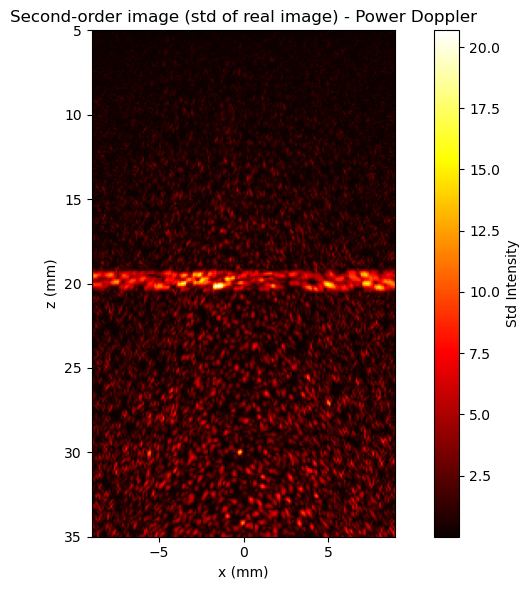

In [24]:
# Second-order: standard deviation
imgs_env = np.array([np.real(img) for img in imgs_complex])
img_std = imgs_env.std(axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(
    img_std,
    extent=[x[0] * 1e3, x[-1] * 1e3, z[-1] * 1e3, z[0] * 1e3],
    aspect="equal",
    cmap="hot",
)
plt.xlabel("x (mm)")
plt.ylabel("z (mm)")
plt.title("Second-order image (std of real image) - Power Doppler")
plt.colorbar(label="Std Intensity")

plt.tight_layout()
plt.show()

Now the whole volume has visible movement, and the artery is much less visible. Clutter from tissue movement tends to be low-rank and high power: highly spatially coherent. Meanwhile, movement from the blood tends to be incoherent. Thus, it's standard to isolate clutter vs. blood using the SVD, so-called **Spatiotemporal Clutter Filtering**. Let's visualize the singular vectors of the volume:

In [25]:
imgs_env = np.array([np.real(img) for img in imgs_complex])
U, S, Vh = np.linalg.svd(imgs_env.reshape(len(imgs_env), -1), full_matrices=False)

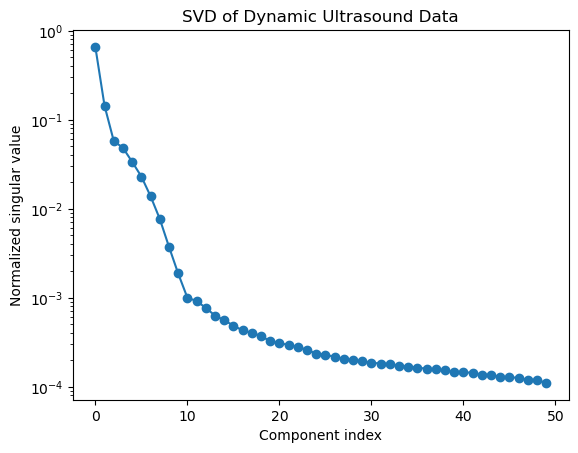

In [26]:
plt.plot(S / S.sum(), "o-")
plt.xlabel("Component index")
plt.ylabel("Normalized singular value")
plt.title("SVD of Dynamic Ultrasound Data")
plt.yscale("log")

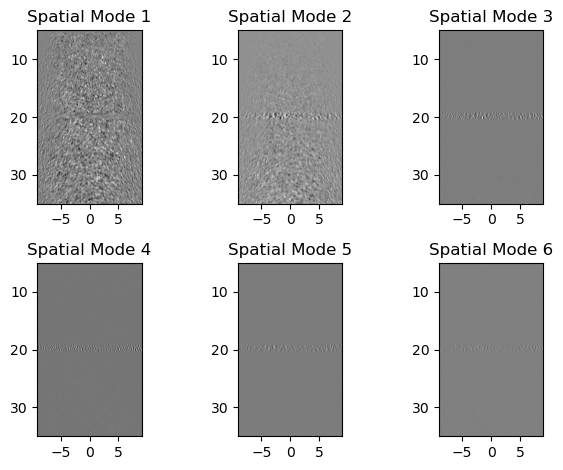

In [27]:
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(
        Vh[i, :].reshape(imgs_env.shape[1:]),
        cmap="gray",
        extent=[x[0] * 1e3, x[-1] * 1e3, z[-1] * 1e3, z[0] * 1e3],
    )
    plt.title(f"Spatial Mode {i+1}")
plt.tight_layout()

As we can see, the first spatial component is a broad DC component, the second is mixed between the artery and a global component, while spatial modes 3 and onwards only include the artery region. We can thus reject the first two components to recover a "decluttered" Power Doppler signal.

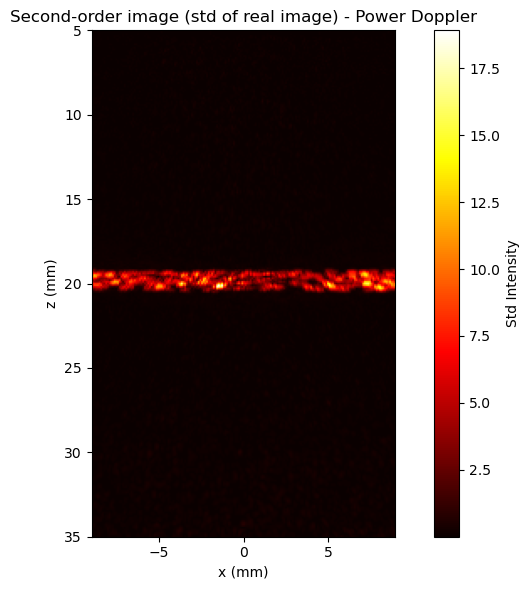

In [28]:
S[:2] = 0
imgs_env_denoised = (U @ np.diag(S) @ Vh).reshape(imgs_env.shape)
img_std = imgs_env_denoised.std(axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(
    img_std,
    extent=[x[0] * 1e3, x[-1] * 1e3, z[-1] * 1e3, z[0] * 1e3],
    aspect="equal",
    cmap="hot",
)
plt.xlabel("x (mm)")
plt.ylabel("z (mm)")
plt.title("Second-order image (std of real image) - Power Doppler")
plt.colorbar(label="Std Intensity")

plt.tight_layout()
plt.show()

Other options for decluttering include high-pass spatio-temporal filtering.

## Conclusion

- Power Doppler is constructed by measuring how ultrafast ultrasound images change over time (specifically, their standard deviation)
- The PD signal is sensitive to the square root of the density of moving scatterers. In the brain, that means sensitivity to cerebral blood volume (CBV), a proxy of neural activity
- Global motion, which has many sources---elastic deformations in the brain, movement of the probe with respect to the brain, etc.---can drown out true localized signals
- Clutter filtering through the SVD is one way of discounting global motion and recovering local changes in scatterer distribution

See the **Bonus section** below for how to extract additional information about blood flow speed from the autocorrelation function.

## Key references

* [Macé et al. (2011)](https://www.nature.com/articles/nmeth.1641), Functional ultrasound imaging of the brain.
* [Demené et al. (2015)](https://ieeexplore.ieee.org/abstract/document/7098422), Spatiotemporal Clutter Filtering of Ultrafast Ultrasound Data Highly Increases Doppler and fUltrasound Sensitivity.
* [Tang et al. 2020](https://advanced.onlinelibrary.wiley.com/doi/full/10.1002/advs.202001044). Functional Ultrasound Speckle Decorrelation-Based Velocimetry of the Brain.

# Bonus: Extracting Flow Speed from Autocorrelation

We've just seen that the Power Doppler signal gives us information about the density of moving scatterers in the blood. But it's possible to extract another measure of blood flow from the **autocorrelation** of the signal. Together, these two pieces of information give us complementary views of the change in blood flow and volume over time.

Beyond the PD signal, we can look at the first-order (discrete) correlation function:

$$A(k) = \frac{1}{N-k} \sum_i \tilde s(i) \tilde s ^*(i - k)$$

Here $\tilde s(i)$ is the i'th (complex) beamformed image in a sequence, with the temporal mean subtracted. The correlation function tells us how fast the reconstructed images change over time, which ultimately relates to flow. Note that with this definition, the PD signal is the square root of $A(0)$.

In [29]:
def norm_autocorr(x):
    """Compute normalized autocorrelation of 1D signal x."""
    assert x.shape[0] % 2 == 0, "Input length must be even"
    xp = x.copy()

    # We do the convolution in Fourier domain for speed
    # We have to be careful about circular boundary conditions here, so we pad with zeros
    if x.ndim == 2:
        xp = np.pad(
            xp,
            ((len(x) // 2 - 1, len(x) // 2), (0, 0)),
            mode="constant",
            constant_values=0,
        )
    elif x.ndim == 3:
        xp = np.pad(
            xp,
            ((len(x) // 2 - 1, len(x) // 2), (0, 0), (0, 0)),
            mode="constant",
            constant_values=0,
        )
    F = np.fft.fft(xp, axis=0)
    auto_corr = np.fft.ifft(F * np.conj(F), axis=0)
    auto_corr = np.fft.fftshift(auto_corr, axes=0)

    # This raw autocorrelation needs to be normalized by the number of elements that are summed
    norm_factor = len(x) - abs(np.arange(-len(x) + 1, len(x)))
    if x.ndim == 2:
        auto_corr /= norm_factor.reshape(-1, 1)
    elif x.ndim == 3:
        auto_corr /= norm_factor.reshape(-1, 1, 1)

    # Pick the central part
    quarter = auto_corr.shape[0] // 4
    auto_corr = auto_corr[quarter : len(auto_corr) - quarter - 1]
    return auto_corr

Let's compute the autocorrelation for the 200-frame simulation we ran earlier in the "Sensitivity to speed" section. We need to re-run that simulation to have the data available.

In [30]:
# Re-run the 200-frame simulation for autocorrelation analysis
fps = 100  # frames per second
flow_speed = 0.002

# Define blood vessel region (horizontal stripe)
vessel_z_min = 0.019  # 19 mm
vessel_z_max = 0.020  # 20 mm

print(f"\nBlood vessel region: z = {vessel_z_min*1e3:.1f} to {vessel_z_max*1e3:.1f} mm")
print("Flow direction: rightward (+x)")

# Reset scatterers to initial positions
scat_pos_test, scat_amP = sample_scatterers(P)

# Identify scatterers in the vessel region
z_coords = scat_pos_test[:, 1]
vessel_mask = (z_coords >= vessel_z_min) & (z_coords <= vessel_z_max)

print(f"Scatterers in vessel: {vessel_mask.sum()} / {len(scat_amP)}")

# Run simulations
n_frames_test = 200
Ys_test = []

for i in tqdm(range(n_frames_test)):
    # Simulate current frame
    Y_test, times, elem_pos_test, _, _, _ = simulate_forward_channels_vectorized(
        P, scat_pos_test, scat_amP
    )
    Ys_test.append(Y_test)

    # Move scatterers in vessel region coherently to the right
    if i < n_frames_test - 1:
        # Coherent rightward motion for scatterers in vessel
        displacement = np.zeros_like(scat_pos_test)
        displacement[vessel_mask, 0] = flow_speed / fps  # Move right (+x)

        # Optional: add small random perturbation for realism
        displacement[vessel_mask] += np.random.normal(
            scale=flow_speed * 0.1 / fps, size=(vessel_mask.sum(), 2)
        )

        scat_pos_test += displacement
        # Wrap around scatterers that move beyond x_span
        scat_pos_test[:, 0] = (scat_pos_test[:, 0] - P.x_span[0]) % (
            P.x_span[1] - P.x_span[0]
        ) + P.x_span[0]

# Beamform all frames
imgs_complex_test = []
for Y_test in tqdm(Ys_test, desc="Beamforming"):
    img_complex_test = beamform_das_vectorized(
        Y_test, times, elem_pos_test, x, z, P.c, betas, 2 * np.pi * P.f_carrier, alpha
    )
    imgs_complex_test.append(img_complex_test)

# Compute envelope
imgs_env_test = np.array([np.abs(img) for img in imgs_complex_test])

# Create mask for pixels in the vessel region
X_grid, Z_grid = np.meshgrid(x, z)
middle_line = int(np.where((z >= vessel_z_min) & (z <= vessel_z_max))[0].mean())

# Pick the middle line in the vessel region
center_pos = imgs_env_test[:, middle_line, :]


Blood vessel region: z = 19.0 to 20.0 mm
Flow direction: rightward (+x)
Scatterers in vessel: 246 / 8000


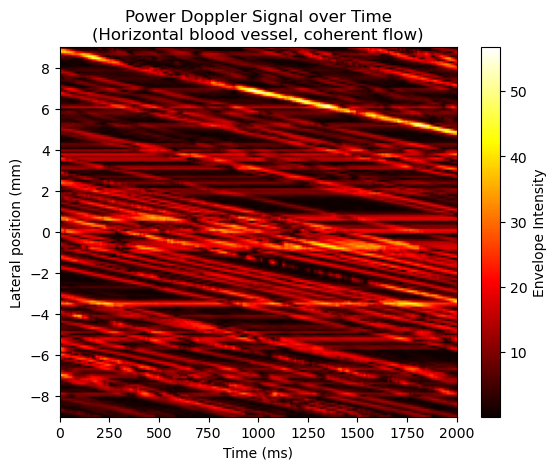

In [31]:
# Visualize the signal over time
plt.imshow(
    center_pos.T,
    aspect="auto",
    cmap="hot",
    extent=[0, n_frames_test / fps * 1000, x[0] * 1e3, x[-1] * 1e3],
)
plt.xlabel("Time (ms)")
plt.ylabel("Lateral position (mm)")
plt.title("Power Doppler Signal over Time\n(Horizontal blood vessel, coherent flow)")
plt.colorbar(label="Envelope Intensity")

The signal drifts very slowly over time (at the speed of blood flow, 2 mm/s). Now let's compute the autocorrelation:

(-500.0, 500.0)

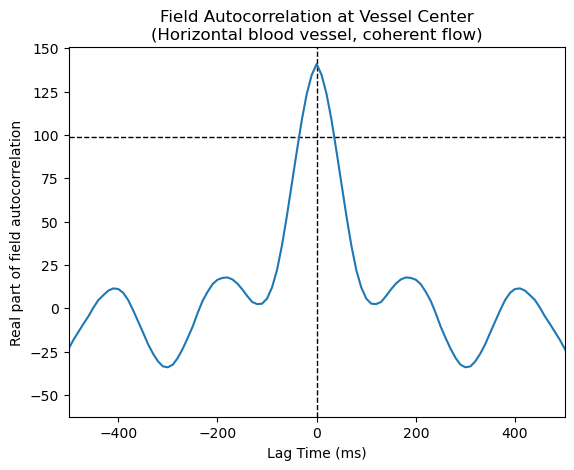

In [32]:
imgs_env_test_complex = np.array([img for img in imgs_complex_test])

# Take the first order correlation
zs, xs = middle_line, imgs_env_test_complex.shape[2] // 2
auto_corr = norm_autocorr(
    imgs_env_test_complex - imgs_env_test_complex.mean(axis=0, keepdims=True)
).real
rel_auto_corr = np.real(auto_corr[:, zs, xs])

rg = np.arange(-auto_corr.shape[0] // 2, auto_corr.shape[0] // 2) / fps * 1000
plt.axhline(y=rel_auto_corr.max() * 0.7, color="k", linestyle="--", linewidth=1)
plt.axvline(x=0, color="k", linestyle="--", linewidth=1)
plt.plot(rg, rel_auto_corr)
plt.xlabel("Lag Time (ms)")
plt.ylabel("Real part of field autocorrelation")
plt.title(
    "Field Autocorrelation at Vessel Center\n(Horizontal blood vessel, coherent flow)"
)
plt.xlim(-500, 500)

## Decorrelation time estimation

Let's estimate a decorrelation time, which we'll define as the first time point where the autocorrelation falls to 70% of its peak (see horizontal line above). We'll use linear interpolation to get better resolution than the native 10 millisecond resolution.

In [33]:
def find_decorrelation_time(autocorr, threshold=0.7):
    """
    Find the time index where autocorrelation falls below threshold using linear interpolation.

    Parameters:
    -----------
    autocorr : array of shape (n_lags, ...)
        Autocorrelation function, assumed to start at 1 and be monotonically decreasing
    threshold : float
        Threshold value (default 0.7)

    Returns:
    --------
    decorr_idx : array of shape (...)
        Decorrelation time index (with sub-sample precision via interpolation)
        Returns NaN if threshold is never crossed
    """
    # Normalize so it starts at 1
    autocorr_norm = autocorr / autocorr[0:1]

    # Find first index where we drop below threshold for each spatial position
    below_threshold = autocorr_norm < threshold

    # Get the first index where condition is true
    # argmax returns 0 for all-False, so we need to check
    first_below = np.argmax(below_threshold, axis=0)

    # Check if threshold was actually crossed (not all False)
    never_crosses = ~below_threshold.any(axis=0)

    # For positions where threshold is crossed, use linear interpolation
    # between the last point above threshold and first point below
    decorr_idx = np.zeros_like(first_below, dtype=float)

    # Flatten for easier iteration
    original_shape = first_below.shape
    first_below_flat = first_below.ravel()
    decorr_idx_flat = decorr_idx.ravel()
    never_crosses_flat = never_crosses.ravel()

    for i in range(len(first_below_flat)):
        if never_crosses_flat[i] or first_below_flat[i] == 0:
            # Never crossed or started below threshold
            decorr_idx_flat[i] = np.nan
        else:
            idx_below = first_below_flat[i]
            idx_above = idx_below - 1

            # Get values at these indices
            if autocorr_norm.ndim == 1:
                val_above = autocorr_norm[idx_above]
                val_below = autocorr_norm[idx_below]
            else:
                # Handle multi-dimensional case
                idx_tuple_above = (idx_above,) + np.unravel_index(i, original_shape)
                idx_tuple_below = (idx_below,) + np.unravel_index(i, original_shape)
                val_above = autocorr_norm[idx_tuple_above]
                val_below = autocorr_norm[idx_tuple_below]

            # Linear interpolation: find exact position where it crosses threshold
            # val_above + t * (val_below - val_above) = threshold
            # t = (threshold - val_above) / (val_below - val_above)
            if val_below != val_above:
                t = (threshold - val_above) / (val_below - val_above)
                decorr_idx_flat[i] = idx_above + t
            else:
                decorr_idx_flat[i] = idx_above

    decorr_idx = decorr_idx_flat.reshape(original_shape)

    return decorr_idx


decorr_time_idx = find_decorrelation_time(
    np.fft.fftshift(rel_auto_corr, axes=0), threshold=0.7
)
decorr_time_ms = decorr_time_idx / fps * 1000  # Convert to milliseconds
print(f"Decorrelation time: {decorr_time_ms:.1f} ms")

Decorrelation time: 35.5 ms


## Decorrelation time vs. averaging window

Just like the PD signal depends on the averaging window, so does the decorrelation time estimate:

Text(0.5, 1.0, 'Decorrelation Time vs. Averaging Window')

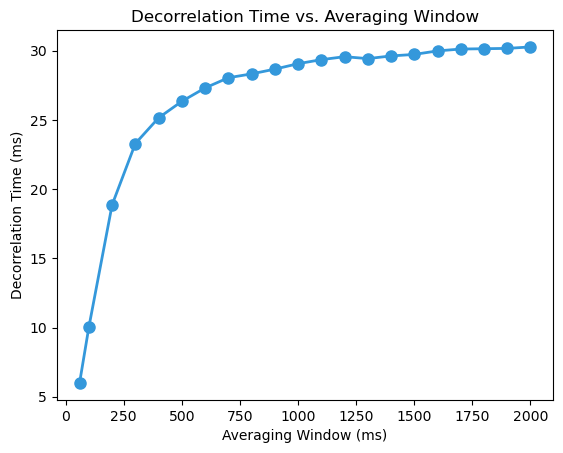

In [34]:
x_coords = np.linspace(P.x_span[0], P.x_span[1], imgs_env_test_complex.shape[2])

# Pick the middle line in the vessel region
center_pos_complex = imgs_env_test_complex[:, middle_line, :]
decorr_signals = []
num_frames = np.array(
    [
        6,
        10,
        20,
        30,
        40,
        50,
        60,
        70,
        80,
        90,
        100,
        110,
        120,
        130,
        140,
        150,
        160,
        170,
        180,
        190,
        200,
    ]
)
for nf in num_frames:
    center_signal = center_pos_complex[:nf, :]
    center_signal = center_signal - center_signal.mean(axis=0, keepdims=True)
    con = norm_autocorr(center_signal)
    con = np.fft.fftshift(con, axes=0).real
    # Find the first position the correlation function falls below 70% of its max
    decorrelation_times = (
        find_decorrelation_time(con, threshold=0.7) / fps * 1e3
    )  # in ms
    decorr_signals.append(
        decorrelation_times[(x_coords >= -5e-3) & (x_coords <= 5e-3)].mean()
    )

plt.plot(
    num_frames / fps * 1000,
    decorr_signals,
    "o-",
    linewidth=2,
    markersize=8,
    color="#3498db",
)
plt.xlabel("Averaging Window (ms)")
plt.ylabel("Decorrelation Time (ms)")
plt.title("Decorrelation Time vs. Averaging Window")

The decorrelation time estimate is also sensitive to the averaging window, similar to the PD signal. This is because we need enough samples to accurately estimate the autocorrelation.

## Decorrelation time vs. scatterer density

Unlike the PD signal, the decorrelation time should be insensitive to scatterer density (since it reflects flow speed, not volume):

Scatterers in vessel: 240 / 8000


Scatterers in vessel: 385 / 8128


Scatterers in vessel: 536 / 8268


Scatterers in vessel: 1100 / 8825


Scatterers in vessel: 2104 / 9841


Scatterers in vessel: 4336 / 12065


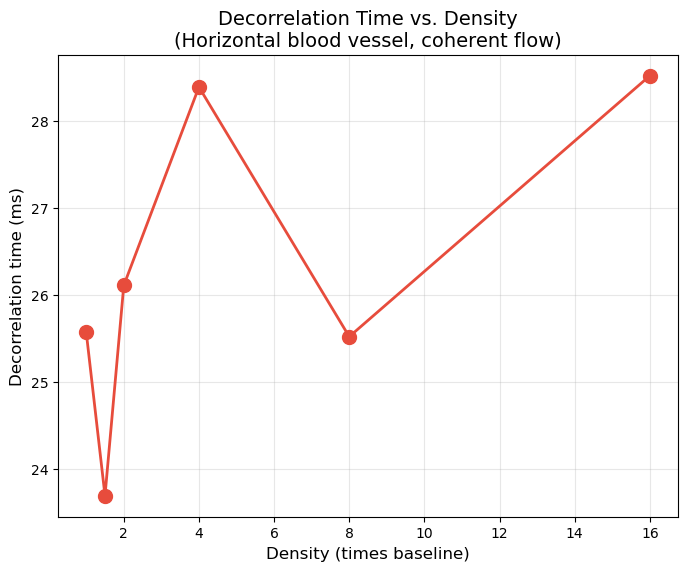

In [35]:
# Test decorrelation time vs density
fps = 100  # frames per second
flow_speed = 0.002

# Define blood vessel region (horizontal stripe)
vessel_z_min = 0.019  # 19 mm
vessel_z_max = 0.020  # 20 mm

# Storage for results
decorr_signals_density = []

densities = np.array([1, 1.5, 2, 4, 8, 16])

for density in densities:

    # Reset scatterers to initial positions
    scat_pos_test, scat_amP = sample_scatterers(P)

    # Identify scatterers in the vessel region
    z_coords = scat_pos_test[:, 1]
    vessel_mask = (z_coords >= vessel_z_min) & (z_coords <= vessel_z_max)

    # Add more scatterers in the vessel region for better SNR
    if density > 1:
        # Sample additional scatterers in the vessel region
        n_additional_scat = int(vessel_mask.sum() * (density - 1))
        x_add, z_add = np.random.uniform(
            low=[P.x_span[0], vessel_z_min],
            high=[P.x_span[1], vessel_z_max],
            size=(n_additional_scat, 2),
        ).T
        scat_pos_test = np.vstack([scat_pos_test, np.column_stack([x_add, z_add])])
        scat_amP = np.hstack(
            [scat_amP, np.random.normal(loc=0, scale=1, size=n_additional_scat)]
        )

        vessel_mask = (scat_pos_test[:, 1] >= vessel_z_min) & (
            scat_pos_test[:, 1] <= vessel_z_max
        )

    print(f"Scatterers in vessel: {vessel_mask.sum()} / {len(scat_amP)}")

    # Run simulations
    n_frames_test = 50
    Ys_test = []

    for i in tqdm(range(n_frames_test), desc=f"Density {density}X"):
        # Simulate current frame
        Y_test, t_test, elem_pos_test, _, _, _ = simulate_forward_channels_vectorized(
            P, scat_pos_test, scat_amP
        )
        Ys_test.append(Y_test)

        # Move scatterers in vessel region coherently to the right
        if i < n_frames_test - 1:
            # Coherent rightward motion for scatterers in vessel
            displacement = np.zeros_like(scat_pos_test)
            displacement[vessel_mask, 0] = flow_speed / fps  # Move right (+x)

            # Optional: add small random perturbation for realism
            displacement[vessel_mask] += np.random.normal(
                scale=flow_speed * 0.1 / fps, size=(vessel_mask.sum(), 2)
            )

            scat_pos_test += displacement
            # Wrap around scatterers that move beyond x_span
            scat_pos_test[:, 0] = (scat_pos_test[:, 0] - P.x_span[0]) % (
                P.x_span[1] - P.x_span[0]
            ) + P.x_span[0]

    # Beamform all frames
    imgs_complex_test = []
    for Y_test in tqdm(Ys_test, desc="Beamforming"):
        img_complex_test = beamform_das_vectorized(
            Y_test, t_test, elem_pos, x, z, P.c, betas, 2 * np.pi * P.f_carrier, alpha
        )
        imgs_complex_test.append(img_complex_test)

    # Compute envelope and variance
    imgs_env_test = np.array([img for img in imgs_complex_test])
    middle_line = int(np.where((z >= vessel_z_min) & (z <= vessel_z_max))[0].mean())
    center_pos = imgs_env_test[:, middle_line, :]

    center_signal = center_pos - center_pos.mean(axis=0, keepdims=True)
    con = norm_autocorr(center_signal)
    con = np.fft.fftshift(con, axes=0).real
    # Find the first position the correlation function falls below 70% of its max
    decorrelation_times = (
        find_decorrelation_time(con, threshold=0.7) / fps * 1e3
    )  # in ms
    decorr_signals_density.append(
        decorrelation_times[(x >= -5e-3) & (x <= 5e-3)].mean()
    )

decorr_signals_density = np.array(decorr_signals_density)

# Plot results
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

ax1.plot(
    densities, decorr_signals_density, "o-", linewidth=2, markersize=10, color="#e74c3c"
)
ax1.set_xlabel("Density (times baseline)", fontsize=12)
ax1.set_ylabel("Decorrelation time (ms)", fontsize=12)
ax1.set_title(
    "Decorrelation Time vs. Density\n(Horizontal blood vessel, coherent flow)",
    fontsize=14,
)
ax1.grid(True, alpha=0.3)

Notice that the decorrelation time is approximately the same at all densities, as expected! This confirms that:

- **Power Doppler** primarily reflects blood *volume*/number of scatterers, with the caveats noted above
- **Decorrelation time** primarily reflects blood *flow speed*

Together, these complementary measures give us ways of measuring correlates of cerebral blood flow (CBF) and cerebral blood volume (CBV) proxies from functional ultrasound data.
